# Importing and install

In [ ]:
!pip install wandb
!pip install tensorflow==2.10.1
!pip install git+https://github.com/okankop/vidaug.git

In [ ]:

import io
import imageio
import ipywidgets
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.utils import to_categorical
from tensorflow.keras import layers
import wandb
import os

from wandb.keras import WandbCallback
import PIL
import matplotlib.pyplot as plt
from PIL import Image
from keras_preprocessing.image import img_to_array, load_img
import vidaug
from vidaug import augmentors as va
# Setting seed for reproducibility
SEED = 42

os.environ["TF_CUDNN_DETERMINISTIC"] = "1"
os.environ['PYTHONHASHSEED']='0'
tf.keras.utils.set_random_seed(SEED)
import warnings
warnings.filterwarnings('ignore')

#Dataset preparation

In [ ]:
%cd '/content/drive/MyDrive/obj-3'  ##Path to current project directory
import sys
from sf_gru_o import SFGRU
sys.path.insert(0,'/content/drive/MyDrive/vmi/PIE')  ### Path to PIE Dataset
from pie_data import PIE

data_opts ={'fstride': 1,
            'subset': 'default',
            'data_split_type': 'random',  # kfold, random, default
            'seq_type': 'crossing',
            'min_track_size': 75} ## for obs length of 15 frames + 60 frames tte. This should be adjusted for different setup
imdb = PIE(data_path='/content/drive/MyDrive/vmi/PIE')  ### Path to PIE Dataset

model_opts = {'obs_input_type': ['local_box', 'ped_id', 'box_org', 'speed'],
              'enlarge_ratio': 1.5,
              'pred_target_type': ['crossing'],
              'obs_length': 15,  # Determines min track size
              'time_to_event': 60, # Determines min track size
              'dataset': 'pie',
              'normalize_boxes': True}

method_class = SFGRU()
beh_seq_train = imdb.generate_data_trajectory_sequence('train', **data_opts)
beh_seq_val = imdb.generate_data_trajectory_sequence('val', **data_opts)
beh_seq_test = imdb.generate_data_trajectory_sequence('test', **data_opts)
train_data = method_class.get_data({'train': beh_seq_train}, model_opts)
val_data = method_class.get_data({'val': beh_seq_val}, model_opts)
test_data = method_class.get_data({'test': beh_seq_test}, model_opts)


In [ ]:
train_set,t_data_types,t_data_sizes = train_data
val_set,v_data_types,v_data_sizes = val_data
test_set, te_data_types, te_data_sizes = test_data
x_train = train_set['train'][0]
y_train = train_set['train'][1]
x_val = val_set['val'][0]
y_val = val_set['val'][1]
x_test = test_set['test'][0]
y_test = test_set['test'][1]

In [ ]:
def bbox_sanity_check(img_size, bbox):
	"""
	Confirms that the bounding boxes are within image boundaries.
	If this is not the case, modifications is applied.
	:param img_size: The size of the image
	:param bbox: The bounding box coordinates
	:return: The modified/original bbox
	"""
	img_width, img_heigth = img_size
	if bbox[0] < 0:
		bbox[0] = 0.0
	if bbox[1] < 0:
		bbox[1] = 0.0
	if bbox[2] >= img_width:
		bbox[2] = img_width - 1
	if bbox[3] >= img_heigth:
		bbox[3] = img_heigth - 1
	return bbox


In [ ]:
def squarify(bbox, squarify_ratio, img_width):
	"""
	Changes is the ratio of bounding boxes to a fixed ratio
	:param bbox: Bounding box
	:param squarify_ratio: Ratio to be changed to
	:param img_width: Image width
	:return: Squarified boduning box
	"""
	width = abs(bbox[0] - bbox[2])
	height = abs(bbox[1] - bbox[3])
	width_change = height * squarify_ratio - width
	bbox[0] = bbox[0] - width_change/2
	bbox[2] = bbox[2] + width_change/2
	# Squarify is applied to bounding boxes in Matlab coordinate starting from 1
	if bbox[0] < 0:
		bbox[0] = 0

	# check whether the new bounding box goes beyond image boarders
	# If this is the case, the bounding box is shifted back
	if bbox[2] > img_width:
		# bbox[1] = str(-float(bbox[3]) + img_dimensions[0])
		bbox[0] = bbox[0]-bbox[2] + img_width
		bbox[2] = img_width
	return bbox

In [ ]:
def jitter_bbox(img_path, bbox, mode, ratio):
	"""
	This method jitters the position or dimensions of the bounding box.
	:param img_path: The to the image
	:param bbox: The bounding box to be jittered
	:param mode: The mode of jittere:
	'same' returns the bounding box unchanged
		  'enlarge' increases the size of bounding box based on the given ratio.
		  'random_enlarge' increases the size of bounding box by randomly sampling a value in [0,ratio)
		  'move' moves the center of the bounding box in each direction based on the given ratio
		  'random_move' moves the center of the bounding box in each direction by randomly
						sampling a value in [-ratio,ratio)
	:param ratio: The ratio of change relative to the size of the bounding box.
		   For modes 'enlarge' and 'random_enlarge'
		   the absolute value is considered.
	:return: Jittered bounding box
	"""

	assert(mode in ['same','enlarge','move','random_enlarge','random_move']), \
			'mode %s is invalid.' % mode

	if mode == 'same':
		return bbox

	img = load_img(img_path)

	if mode in ['random_enlarge', 'enlarge']:
		jitter_ratio  = abs(ratio)
	else:
		jitter_ratio  = ratio

	if mode == 'random_enlarge':
		jitter_ratio = np.random.random_sample()*jitter_ratio
	elif mode == 'random_move':
		# for ratio between (-jitter_ratio, jitter_ratio)
		# for sampling the formula is [a,b), b > a,
		# random_sample * (b-a) + a
		jitter_ratio = np.random.random_sample() * jitter_ratio * 2 - jitter_ratio

	jit_boxes = []
	for b in bbox:
		bbox_width = b[2] - b[0]
		bbox_height = b[3] - b[1]

		width_change = bbox_width * jitter_ratio
		height_change = bbox_height * jitter_ratio

		if width_change < height_change:
			height_change = width_change
		else:
			width_change = height_change

		if mode in ['enlarge','random_enlarge']:
			b[0] = b[0] - width_change //2
			b[1] = b[1] - height_change //2
		else:
			b[0] = b[0] + width_change //2
			b[1] = b[1] + height_change //2

		b[2] = b[2] + width_change //2
		b[3] = b[3] + height_change //2

		# Checks to make sure the bbox is not exiting the image boundaries
		b = bbox_sanity_check(img.size, b)
		jit_boxes.append(b)
	# elif crop_opts['mode'] == 'border_only':
	return jit_boxes

In [ ]:
def img_pad(img, mode = 'warp', size = 224):
	"""
	Pads a image given the boundries of the box needed
	:param img: The image to be coropped and/or padded
	:param mode: The type of padding or resizing:
			warp: crops the bounding box and resize to the output size
			same: only crops the image
			pad_same: maintains the original size of the cropped box  and pads with zeros
			pad_resize: crops the image and resize the cropped box in a way that the longer edge is equal to
						the desired output size in that direction while maintaining the aspect ratio. The rest
						of the image is	padded with zeros
			pad_fit: maintains the original size of the cropped box unless the image is bigger than the size
					in which case it scales the image down, and then pads it
	:param size: Target size of image
	:return:
	"""
	assert(mode in ['same', 'warp', 'pad_same', 'pad_resize', 'pad_fit']), 'Pad mode %s is invalid' % mode
	image = img.copy()
	if mode == 'warp':
		warped_image = image.resize((size,size), PIL.Image.NEAREST)
		return warped_image
	elif mode == 'same':
		return image
	elif mode in ['pad_same', 'pad_resize', 'pad_fit']:
		img_size = image.size  # size is in (width, height)
		ratio = float(size)/max(img_size)
		if mode == 'pad_resize' or	\
			(mode == 'pad_fit' and (img_size[0] > size or img_size[1] > size)):
			img_size = tuple([int(img_size[0]*ratio),int(img_size[1]*ratio)])
			image = image.resize(img_size, PIL.Image.NEAREST)
		padded_image = PIL.Image.new("RGB", (size, size))
		padded_image.paste(image, ((size-img_size [0])//2,
					(size-img_size [1])//2))
		return padded_image



Data Augementation

In [ ]:

# sometimes = lambda aug: va.Sometimes(0.2, aug) # Used to apply augmentor with 50% probability
seq = va.Sequential([
    # va.RandomCrop(size=(240, 180)), # randomly crop video with a size of (240 x 180)
    va.RandomRotate(degrees=15), # randomly rotates the video with a degree randomly choosen from [-10, 10]
    va.HorizontalFlip(), # horizontally flip the video with 50% probability
    va.GaussianBlur(0.9),
    va.Add(50),
    va.Multiply(2)
])


In [ ]:
#Custom Data Generator
import tensorflow as tf
import PIL

import random
import numpy as np
class CustomDataGen(tf.keras.utils.Sequence):

    def __init__(self,x, y,
                 batch_size,
                 input_size=(224, 224, 3),
                 shuffle=True, train=1):


        self.x=x
        self.y = y
        self.batch_size = batch_size
        self.input_size = input_size
        self.shuffle = shuffle
        self.train= train
        self.n = len(self.y)


    def on_epoch_end(self):
        if self.shuffle:
            ind = np.random.randint(0, len(self.y), len(self.y))
            self.x[0] = self.x[0][ind]
            self.x[1] = self.x[1][ind]
            self.x[2] = self.x[2][ind]
            self.x[3] = self.x[3][ind]
            self.y = self.y[ind]


    def __get_input(self, path_batch, bbox, target_size, seg=0, test=0):


      if seg==0:
        img_seq=[]
        for path,b in zip(path_batch,bbox):


           flip_image=False
           if 'flip' in path:
                        path = path.replace('_flip', '')

                        flip_image = True

           img= tf.keras.preprocessing.image.load_img(path)

           if flip_image:
              img = img.transpose(Image.FLIP_LEFT_RIGHT)

           box = list(map(int, b[0:4]))
          #  box = jitter_bbox(path, [box], 'enlarge', 1)[0]

           box = squarify(box, 1, img.size[0])
           cropped_image = img.crop(box)
           img_data = img_pad(cropped_image, mode='pad_resize', size=224)


           if test:
              img_seq.append(img_to_array(img_data)/255)
           else:
              img_seq.append(img_to_array(img_data))


      elif seg==1:
        img_seq=[]
        for path,b in zip(path_batch,bbox):
           path = path.replace('images','seg_images')

           flip_image=False
           if 'flip' in path:
                        path = path.replace('_flip', '')

                        flip_image = True
           img= tf.keras.preprocessing.image.load_img(path)

           if flip_image:
              img = img.transpose(Image.FLIP_LEFT_RIGHT)

           img_data = img_pad(img, mode='warp', size=224)
           img_seq.append(img_to_array(img_data)/255)

      elif seg==2:
          img_seq=[]
          for b in bbox:
            x_centre = (b[0] + b[2])/2
            y_centre = (b[1] + b[3])/2
            width = np.abs(b[0] - b[2])
            height = np.abs(b[1] - b[3])
            b = (x_centre, y_centre, width, height)
            img_seq.append(b)

      else:
          img_seq=[]
          for s in bbox:
            img_seq.append(s)

      return img_seq



    def __get_output(self, label, num_classes):
        return tf.keras.utils.to_categorical(label, num_classes=num_classes)

    def __get_data(self, batches_i, batches_b, batch_y):
        # Generates data containing batch_size samples

        image_batch = batches_i
        bbox_batch = batches_b


        label_batch = batch_y
        x_bat=[]
        x_seg_bat=[]
        x_bbox_bat=[]

        y_bat=[]

        for i,j in zip(image_batch, bbox_batch):

          if self.train:
            inp = seq(self.__get_input(i, j, self.input_size, seg=0))
          else:
            inp = self.__get_input(i, j, self.input_size, seg=0, test=1)
          x_bat.append(inp)

        X_batch =np.asarray(x_bat)

        for i,j in zip(image_batch, bbox_batch):
          if self.train:
            inp = seq(self.__get_input(i, j, self.input_size, seg=1))
          else:
            inp = self.__get_input(i, j, self.input_size, seg=1)
          x_seg_bat.append(self.__get_input(i, j, self.input_size, seg=1))
        X_seg_batch =np.asarray(x_seg_bat)


        for i,j in zip(image_batch, bbox_batch):

            x_bbox_bat.append(self.__get_input(i, j, self.input_size, seg=2))
        X_bbox_batch =np.asarray(x_bbox_bat)

        y_labels = np.asarray([k for k in label_batch])
        y_batch = y_labels
        return X_batch, X_seg_batch, X_bbox_batch, y_batch

    def __getitem__(self, index):

        batches_i = self.x[0][index * self.batch_size:(index + 1) * self.batch_size]
        batches_b = self.x[2][index * self.batch_size:(index + 1) * self.batch_size]

        batch_y = self.y[index * self.batch_size:(index + 1) * self.batch_size]

        X, X_seg, X_box , y = self.__get_data(batches_i, batches_b, batch_y)

        return  [X, X_seg, X_box, y], y

    def __len__(self):
        return self.n // self.batch_size

In [ ]:
# DATA
BATCH_SIZE = 2
INPUT_SHAPE = (14, 224, 224, 3)
INPUT_SHAPE2 = (14, 4)
INPUT_SHAPE3 = (14, 1)
INPUT_SHAPE4 =(1,)
NUM_CLASSES = 2

# OPTIMIZER
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-5

# TRAINING
EPOCHS = 50

# TUBELET EMBEDDING
PATCH_SIZE = (2,8,8)
NUM_PATCHES = (INPUT_SHAPE[0] // PATCH_SIZE[0]) ** 2

# ViViT ARCHITECTURE
LAYER_NORM_EPS = 1e-6
PROJECTION_DIM = 64
# PROJECTION_DIM2= 4
NUM_HEADS = 4

In [ ]:
traingen = CustomDataGen(x_train, y_train, batch_size=BATCH_SIZE, train=1)
valgen = CustomDataGen(x_val, y_val, batch_size=BATCH_SIZE, train=0)
testgen = CustomDataGen(x_test, y_test, batch_size=BATCH_SIZE, train=0)

# View Dataset

In [ ]:
# # len(traingen): total_samples/batch_size
# # traingen[0]: first batch
# # traingen[0][1]: Y_values for batch_size
# # traingen[0][0][0]: RGB X_values for batch_size
# # traingen[0][0][1]: MASK X_values for batch_size
# # traingen[0][0][1][0]: all frames
# # traingen[0][1][0]: Y value for one training sample
# # traingen[0][0][1][0][0]: Image per training sample
import matplotlib.pyplot as plt
plt.imshow(traingen[0][0][0][1][13])

In [ ]:
# # len(traingen): total_samples/batch_size
# # traingen[0]: first batch
# # traingen[0][1]: Y_values for batch_size
# # traingen[0][0][0]: RGB X_values for batch_size
# # traingen[0][0][1]: MASK X_values for batch_size
# # traingen[0][0][1][0]: all frames
# # traingen[0][1][0]: Y value for one training sample
# # traingen[0][0][1][0][0]: Image per training sample
import matplotlib.pyplot as plt
plt.imshow(traingen[0][0][1][1][13])

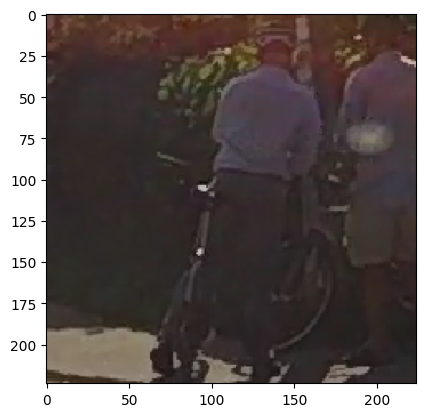

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(valgen[0][0][0][1][13])

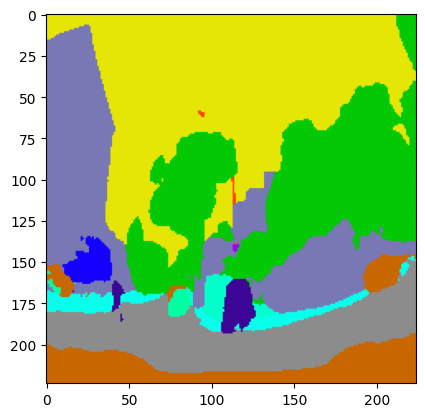

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(valgen[0][0][1][1][13])

# Model Architecture

In [ ]:

class TubeletEmbedding(layers.Layer):
    def __init__(self, embed_dim, patch_size, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim =embed_dim
        self.patch_size = patch_size
        self.projection = layers.Conv3D(
            filters=self.embed_dim,
            kernel_size= self.patch_size,
            strides= self.patch_size,
            padding="VALID",kernel_initializer=keras.initializers.HeNormal(seed=123), activity_regularizer = keras.regularizers.L1(l1=1e-5)
        )
        # self.projection2 = layers.Conv1D(
        #     filters= self.embed_dim,
        #     kernel_size=2,
        #     strides=2,
        #     padding="VALID",kernel_initializer=keras.initializers.HeNormal(seed=123)
        # )
        self.projection2 = layers.GRU(self.embed_dim, return_sequences=True, return_state=True)
        self.flatten = layers.Reshape(target_shape=(-1, embed_dim))

    def call(self, videos, vid):
        if vid==0:
          projected_patches = self.projection(videos)

        elif vid==1:
          projected_patches,_ = self.projection2(videos)


        flattened_patches = self.flatten(projected_patches)
        return flattened_patches

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "patch_size": self.patch_size,
        })
        return config


In [ ]:

class PositionalEncoder(layers.Layer):
    def __init__(self, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim

    def build(self, input_shape):
        _, num_tokens, _ = input_shape
        self.position_embedding = layers.Embedding(
            input_dim=num_tokens, output_dim=self.embed_dim
        )
        self.positions = tf.range(start=0, limit=num_tokens, delta=1)

    def call(self, encoded_tokens):
        # Encode the positions and add it to the encoded tokens
        encoded_positions = self.position_embedding(self.positions)
        encoded_tokens = encoded_tokens + encoded_positions
        return encoded_tokens

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim

        })
        return config

In [ ]:
class PositionalEncoder2(layers.Layer):
    def __init__(self, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim

    def build(self, input_shape):
        _, num_tokens, _ = input_shape
        self.position_embedding = layers.Embedding(
            input_dim=num_tokens, output_dim=self.embed_dim
        )
        self.positions = tf.range(start=0, limit=num_tokens, delta=1)

    def call(self, encoded_tokens):
        # Encode the positions and add it to the encoded tokens
        encoded_positions = self.position_embedding(self.positions)
        encoded_tokens = encoded_tokens + encoded_positions
        return encoded_tokens

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim

        })
        return config

In [ ]:
class Custom_CE_Loss(keras.layers.Layer):
    def __init__(self):
        super(Custom_CE_Loss, self).__init__()
        self.w1 = tf.Variable(0.2,name='w1',trainable=True)
        self.w2 = tf.Variable(0.3,name='w3',trainable=True)
        self.w3 = tf.Variable(0.5,name='w3',trainable=True)

    def get_weights(self):
        return self.w

    def call(self, y_true, y_pred1, y_pred2, y_pred3):
        loss_r = keras.losses.SparseCategoricalCrossentropy(name='loss_r')(y_true, y_pred1)
        loss_rs = keras.losses.SparseCategoricalCrossentropy(name='loss_rs')(y_true, y_pred2)
        loss_rst = keras.losses.SparseCategoricalCrossentropy(name='loss_rst')(y_true, y_pred3)
        return tf.cast(self.w1, float)*loss_r +  tf.cast(self.w2, float)*loss_rs +  tf.cast(self.w3, float)* loss_rst


In [ ]:
tubelet_embedder=TubeletEmbedding(embed_dim=PROJECTION_DIM, patch_size=PATCH_SIZE)
positional_encoder=PositionalEncoder(embed_dim=PROJECTION_DIM)
positional_encoder2=PositionalEncoder2(embed_dim= PROJECTION_DIM)
input_shape=INPUT_SHAPE
input_shape2 = INPUT_SHAPE2
input_shape3 = INPUT_SHAPE3



num_heads=NUM_HEADS
embed_dim=PROJECTION_DIM
layer_norm_eps=LAYER_NORM_EPS
num_classes=NUM_CLASSES


shared_MLP = keras.Sequential(
      [
          layers.Dense(units=embed_dim * 4, activation=tf.nn.gelu, kernel_initializer=keras.initializers.HeNormal(seed=SEED),kernel_regularizer= tf.keras.regularizers.L2(1e-6) ),
          layers.Dropout(0.5),
          layers.Dense(units=embed_dim, activation=tf.nn.gelu, kernel_initializer=keras.initializers.HeNormal(seed=SEED),kernel_regularizer= tf.keras.regularizers.L2(1e-6) ),

      ])
shared_attention1 = layers.MultiHeadAttention(
      num_heads=num_heads, key_dim=embed_dim // num_heads, dropout=0.5
  )
shared_attention2 = layers.MultiHeadAttention(
      num_heads=num_heads, key_dim=embed_dim // num_heads, dropout=0.5
  )
# Get the input layer
input_0 = layers.Input(shape=INPUT_SHAPE, name='RGB')
input_1 = layers.Input(shape=INPUT_SHAPE, name='mask')
input_2 = layers.Input(shape=INPUT_SHAPE2, name='box')
label = layers.Input(shape=INPUT_SHAPE3,name='target')
# Create patches.
patches_0 = tubelet_embedder(input_0, 0)
patches_1 = tubelet_embedder(input_1, 0)
patches_2 = tubelet_embedder(input_2, 1)

# Encode patches.
encoded_patches_0 = positional_encoder(patches_0)
encoded_patches_1 = positional_encoder(patches_1)
encoded_patches_2 = positional_encoder2(patches_2)


encoded_patches = encoded_patches_0

x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)

attention_output = layers.MultiHeadAttention(
      num_heads=num_heads, key_dim=embed_dim // num_heads, dropout=0.5
  )(x1, x1)

x2 = layers.Add()([attention_output, encoded_patches])

  # Layer Normalization and MLP
x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
x3 = shared_MLP(x3)

  # Skip connection
encoded_patches = layers.Add(name='encoded_R')([x3, x2])
representation = layers.LayerNormalization(epsilon=layer_norm_eps)(encoded_patches)
representation = layers.GlobalAvgPool1D()(representation)
representation =layers.Dropout(0.5)(representation)
# Classify outputs.
output_r = layers.Dense(units=2, activation='Softmax', name='rgb_o', kernel_initializer=keras.initializers.HeNormal(seed=SEED))(representation)

#second layer

x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
xn = layers.LayerNormalization(epsilon=1e-6)(encoded_patches_1)

attention_output1 = shared_attention1(x1, xn)

attention_output2 =shared_attention1(xn, x1)

attention = layers.Permute((2,1))(attention_output2)
attention = layers.Conv1D(attention_output1.shape[1], 1)(attention)
attention = layers.Permute((2,1))(attention)
attention_output = layers.Add()([attention_output1, attention])




  # Skip connection
x2 = layers.Add()([attention_output, encoded_patches])

  # Layer Normalization and MLP
x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
x3 = shared_MLP(x3)

#   # Skip connection
encoded_patches = layers.Add()([x3, x2])

representation = layers.LayerNormalization(epsilon=layer_norm_eps)(encoded_patches)
representation = layers.GlobalAvgPool1D()(representation)
representation =layers.Dropout(0.5)(representation)
# Classify outputs.
output_s = layers.Dense(units=2, activation='Softmax', name='seg_o', kernel_initializer=keras.initializers.HeNormal(seed=SEED))(representation)

#   #Third layer

x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
xn = layers.LayerNormalization(epsilon=1e-6)(encoded_patches_2)

attention_output1 = shared_attention2(x1, xn)

attention_output2 = shared_attention2(xn, x1)

attention = layers.Permute((2,1))(attention_output2)
attention = layers.Conv1D(attention_output1.shape[1], 1)(attention)
attention = layers.Permute((2,1))(attention)
attention_output = layers.Add()([attention_output1, attention])




  # Skip connection
x2 = layers.Add()([attention_output, encoded_patches])

  # Layer Normalization and MLP
x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
x3 = shared_MLP(x3)

  # Skip connection
encoded_patches = layers.Add()([x3, x2])

# Layer normalization and Global average pooling.
representation = layers.LayerNormalization(epsilon=layer_norm_eps)(encoded_patches)
representation = layers.GlobalAvgPool1D()(representation)
representation =layers.Dropout(0.5)(representation)
# Classify outputs.
outputs = layers.Dense(units=2, activation='Softmax', name='traj_o', kernel_initializer=keras.initializers.HeNormal(seed=SEED))(representation)

# Create the Keras model.
model = keras.Model(inputs=[input_0, input_1, input_2, label], outputs=[output_r, output_s, outputs])

model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 RGB (InputLayer)               [(None, 14, 224, 22  0           []                               
                                4, 3)]                                                            
                                                                                                  
 tubelet_embedding (TubeletEmbe  multiple            38080       ['RGB[0][0]',                    
 dding)                                                           'mask[0][0]',                   
                                                                  'box[0][0]']                    
                                                                                                  
 positional_encoder (Positional  (None, 5488, 64)    351232      ['tubelet_embedding[0][0]',  

# Training

In [ ]:
lam=0.5
optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
def scheduler(epoch, lr):
  if epoch < 7:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

sched = keras.callbacks.LearningRateScheduler(scheduler)

model.compile(
    optimizer=optimizer,
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=[
        keras.metrics.SparseCategoricalAccuracy(name="accuracy")],)

# wandb.init(project="Intent_final")
# wandb.config = {
# "learning_rate": LEARNING_RATE,
# "epochs": 50,
# "batch_size": 8
#  }
# wand = WandbCallback(
# monitor="val_loss", verbose=0, mode="auto", save_weights_only=(False),
# log_weights=(False), log_gradients=(False), save_model=(False),
# training_data=traingen, validation_data=valgen, labels=['Not Crossing', 'Crossing'], predictions=36,
# generator=None, input_type=None, output_type=None, log_evaluation=(False),
# validation_steps=None, class_colors=None, log_batch_frequency=None,
# log_best_prefix="best_", save_graph=(True), validation_indexes=None,
# validation_row_processor=None, prediction_row_processor=None,
# infer_missing_processors=(True), log_evaluation_frequency=0,
# compute_flops=(False)
# )
early = keras.callbacks.EarlyStopping(
monitor='val_traj_o_accuracy',
min_delta=0,
patience=7,
verbose=0,
mode='max',
baseline=None,
restore_best_weights=True
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5)
epoch=EPOCHS
file_path = '/content/drive/MyDrive/obj-3/model checkpoints4/cp_{epoch:0d}.tf'
cp = keras.callbacks.ModelCheckpoint(filepath=file_path, verbose=1, period=1, monitor='val_traj_o_accuracy', mode='max')
# Train the model.
# print(model.summary())
_ = model.fit(traingen, epochs=EPOCHS, validation_data= valgen, workers=8, callbacks=[reduce_lr, cp, sched])
# _, accuracy, top_5_accuracy = model.evaluate(testgen)
# print(f"Test accuracy: {round(accuracy * 100, 2)}%")
# print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")



# Inference

In [ ]:
checkpoint_path ='/content/drive/MyDrive/obj-3/model checkpoints4/cp_8.tf'

# Load the previously saved weights
model=tf.keras.models.load_model(checkpoint_path)
# model.load_weights(checkpoint_path)

In [ ]:
# model.load_model('/content/drive/MyDrive/obj-3/model checkpoints/cp_1.tf')
# model.evaluate(testgen)

In [ ]:
checkpoint_path ='/content/drive/MyDrive/obj-3/model checkpoints3/cp_6.tf'

# Load the previously saved weights
model2=tf.keras.models.load_model(checkpoint_path)
# model.load_weights(checkpoint_path)

In [ ]:
model2.evaluate(testgen)